In [36]:
import numpy as np


# ----------------------- #
#  Simulation parameters  #
# ----------------------- #
tf = 5000. # final time
dt = 1. # timestep
nt = int(tf/dt) # No. timesteps

''' fixed_density != True  results in a box with sides [-L0/2, L0/2].
    fixed_density = True  rescales the box size according to L = sqrt(N/density) '''
fixed_density = False
L0 = 10.
density = 0.5

''' The following parameters must given as lists/tuples/arrays.
    So a single value must be given as e.g. [x,] or (x,)
    When running from main.py, all combinations will be iterated over.
    When running an animation, the first/only values will be used. '''
N_list = (300,)#, 150, 200, 250, 300,)            # number of particles
v0_list = (0.15,)                    # velocity as a fraction of L
R_list = (1.0,)                     # interaction radius as a fraction of L
eta_list = (0.1,)#list(np.linspace(0.01,0.5,10))+list(np.linspace(0.5,5.0,20))  # noise


# ----------------- #
#  Parallelisation  #
# ----------------- #
Np = 1 # Number of processes


# -------------------- #
#  Data and averaging  #
# -------------------- #
''' Ideally, the time for which the simulation is left to 'burn in' (before data
    is taken) should scale appropriately with different parameter combinations.
    Run python burn_in.py for the SMALLEST values of v0 & R you're using (these are
    the slowest to burn in). This will fit a straight line for the burn-in time
    dependence on N, with coefficients which you should assign to burn_coeff below.
    You might want to run simulations with very different v0, R separately so that
    they don't all need to have the slowest burn-in time.
    WARNING: this doesn't work too well for large systems, small but non-zero eta!'''
burn_coeff = [0, 1] # nt_burn = burn_coeff[0] x N + burn_coeff[1]

# Number of repeated simulations per set of parameters. Minimum 2!
repeats = 2

# Number of samples involved in susceptibility and Binder cumulant error determination
error_samples = 50

# Save file name for statistics (do not include extension: .out will be added automatically)
save_name = "output"

# Save a snapshot of the final state for each parameter combination
save_snapshots = True

# --------- #
#  Leaders  #
# --------- #
N_ldr = 0 # number of leaders
ldr_weight = 9 # effective weight - no. normal particles in leader
ldr_R = 1.5 # multiple of regular interaction radius

''' Can have multiple leaders with different trajectories. These are angular frequencies,
    so they will be multiplied by the current time. The N_ldr-N_ldr_traj leaders without
    a pre-defined trajectory will obey the same rules as normal particles. '''
ldr_traj = np.array([0.02]) # numpy array
N_ldr_traj = min(len(ldr_traj), N_ldr)


# ----------- #
#  Animation  #
# ----------- #
ms = 3 # blob size
lms = np.sqrt(ldr_weight)*ms # leader blob size

''' Set do_plots to True to include animated plots of the order parameter (V) and
    susceptibility (chi). This makes the animation a little slower. '''
do_plots = False # can be overridden using argv[1]=plot: python animate.py plot
window = 50 # number of steps to average over for V,chi plots
plot_step = 10 # number of steps to take before computing and adding new data to OP+sus plots

# Run through values of eta between eta_start & eta_finish
eta_start = 7.
eta_finish = 0.
N_eta_vals = 35
steps_per_eta_val = 50 # int


In [37]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def initial(L, N, v0, R, eta):
    ''' Initialise a single run '''
    state = np.zeros( (N, 5) )
    state[:,:2] = L*np.random.random( (N, 2) ) - 0.5*L # positions x,y
    state[:,2] = 2*np.pi * np.random.random(N) # angle
    state[:,3] = v0 * np.cos(state[:,2]) # x velocity
    state[:,4] = v0 * np.sin(state[:,2]) # y velocity
    
    return state


def step(state, L, N, v0, R, eta, t): 
    ''' Perform one step for all particles '''
    
    # Update positions
    state[:,:2] = state[:,:2] + v0*dt*state[:,3:]
    
    # Periodic boundaries
    crossedX = np.where(abs(state[:,0]) > 0.5*L)
    crossedY = np.where(abs(state[:,1]) > 0.5*L)
    state[crossedX,0] = state[crossedX,0] - np.sign(state[crossedX,0])*L
    state[crossedY,1] = state[crossedY,1] - np.sign(state[crossedY,1])*L
        
    # Initialise heading with noise
    heading = eta*np.random.random(N) - 0.5*eta
    
    # Use adjacency matrix to determine neighbours
    A = squareform(pdist(state[:,:2]))
    for i in range(N):
        adj = np.where(A[i,:] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles

        # Leaders must be treated separately on account of their weight
        ldr_adj = np.where(A[i,:N_ldr] < ldr_R)[0]
        ldr_theta = state[ldr_adj,2]

        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta)) + ldr_weight*np.sum(np.sin(ldr_theta))
        sum_cos = np.sum(np.cos(theta)) + ldr_weight*np.sum(np.cos(ldr_theta))
        
        # Compute heading for this particle
        heading[i] += np.arctan2(sum_sin, sum_cos)
   
    # Update state with new headings
    state[:,2] = heading # Can add an angle here for waveyness
    
    # Some leaders may have pre-defined trajectories
    state[:N_ldr_traj,2] = ldr_traj * t
     
    # Update velocities
    state[:,3] = v0 * np.cos(state[:,2])
    state[:,4] = v0 * np.sin(state[:,2])
    
    return
        

def order_parameter(state, V_coeff):
    ''' Calculate order parameter (V) '''
    
    Vx = np.sum(state[:,3])
    Vy = np.sum(state[:,4])
    return np.sqrt(Vx*Vx + Vy*Vy) * V_coeff


Computing burn-in times for the following parameters:
(v0, R, eta) = (0.15, 1, 0)
dt = 1

(L, N) = (10, 300)
Simulation:
            1/2
            2/2
Fit: nt_burn = 0.325 x N + 97.5


C:\Users\becky\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned


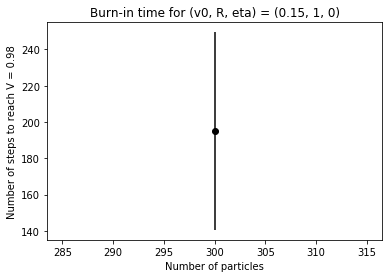

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sys import argv


###############################################################
## Measure burn-in time for different parameter combinations ##
###############################################################

# Set noise to 0 for all simulations
eta = 0

# v0, R are the first values of v0_list and R_list
v0 = v0_list[0]
R = R_list[0]

# Print parameters
print ("Computing burn-in times for the following parameters:")
print ("(v0, R, eta) = (%g, %g, 0)" %(v0,R))
print ("dt = %g" %dt)

# Want to track how far we are through the parameter combinations
numN = len(N_list)
iN = 0

# Initialise lists to hold all results
nt_burn_mean = np.zeros(numN)
nt_burn_stderr = np.zeros(numN)

# Loop over particle numbers
for N in N_list:
    
    # Adjust L if fixed density
    if fixed_density == True:
        L = np.sqrt(N/density)
    else:
        L = L0
    
    V_coeff = 1.0 / (N*v0)
    
    # Create empty arrays for repeats
    nt_burn_repeats = np.zeros(repeats)
    
    print ("")
    print ("(L, N) = (%g, %g)" %(L,N))

    # Loop over repeats
    print ("Simulation:")
    for rep in range(repeats):

        # Print current repeat number
        print ("            %d/%d" %(rep+1,repeats))

        # Create a brand new initial state
        state = initial(L, N, v0, R, eta)
               
        # Initialise V, t and set V_coeff
        V = 0
        t = 0

        # Loop over steps until order parameter hits threshold
        while V < 0.98:
                    
            # All particles take one step
            step(state, L, N, v0, R, eta, t)
            V = order_parameter(state, V_coeff)
            t += 1

        # Save steps to burn in
        nt_burn_repeats[rep] = t

    # End loop over repeats

    # Compute mean and standard deviation of burn-in time
    nt_burn_mean[iN] = np.mean(nt_burn_repeats)
    nt_burn_stderr[iN] = np.std(nt_burn_repeats) / np.sqrt(repeats)
    
    iN += 1


# End loop over particle numbers


##########################
## Plot and attempt fit ##
##########################

fig, ax = plt.subplots()
ax.set_title("Burn-in time for (v0, R, eta) = (%g, %g, 0)" %(v0,R))
ax.set_xlabel("Number of particles")
ax.set_ylabel("Number of steps to reach V = 0.98")

# Plot measured times
ax.errorbar(N_list, nt_burn_mean, yerr=nt_burn_stderr, fmt='ko')

# Linear fit with weights = 1 / error
coeffs = np.polyfit(N_list, nt_burn_mean, 1, w=1.0/nt_burn_stderr)
print ("Fit: nt_burn = %g x N + %g" %(coeffs[0],coeffs[1]))

# Plot fit
fit = np.array(N_list)*coeffs[0] + coeffs[1]
ax.plot(N_list, fit, 'r--')

plt.show()


In [39]:
import numpy as np
from sys import argv


# For parallel runs, index for this process given as argv
if len(argv) > 1:
    pid = int(argv[1])

    # Separate save files for different processes
    save_file = save_name + "_p" + str(pid) + ".out"

else:
    pid = 0
    save_file = save_name + ".out"


# eta_list is partitioned between the processes
eta_list = eta_list[pid::Np]

print ("")
print ("------------------")
print ("| Process no. %02d |" %pid)
print ("------------------")
print ("")
print ("General simulation info:")
if fixed_density == True:
    print ("     Fixed density: %g" %density)
else:
    print ("     Box size: %g x %g" %(L0,L0))
print ("     Simulation time: %g in %g steps of size %g" %(tf,nt,dt))
print ("     %d leaders active" %N_ldr)
print ("     Save file: %s" %save_file)


# Want to track how far we are through the parameter combinations
parameter_combinations = len(N_list) * len(v0_list) * len(R_list) * len(eta_list)
icomb = 0

# Loop over particle numbers
for N in N_list:
    
    # Adjust L if fixed density
    if fixed_density == True:
        L = np.sqrt(N/density)
    else:
        L = L0
    
    # Number of steps for burn-in period
    nt_burn = int( round(burn_coeff[0]*N + burn_coeff[1]) )
        
    # Loop over velocities
    for v0 in v0_list:
        # Loop over interaction radii
        for R in R_list:
            # Loop over noise values
            for eta in eta_list:

                # Print current parameters
                icomb += 1
                print ("")
                print ("Parameter combination %d/%d" %(icomb, parameter_combinations))
                print ("Current parameters: (N, v0, R, eta) = (%d, %g, %g, %g)" %(N,v0,R,eta))
                print ("%d steps for burn-in, %d steps with data-taking" %(nt_burn,nt))

                # Create empty arrays for repeats
                V_mean_repeats = np.zeros(repeats)
                Vsq_mean_repeats = np.zeros(repeats)
                Vqu_mean_repeats = np.zeros(repeats)

                # Loop over repeats
                print ("Simulation:")
                for rep in range(repeats):

                    # Print current repeat number
                    print ("            %d/%d" %(rep+1,repeats))

                    # Create a brand new initial state
                    state = initial(L, N, v0, R, eta)

                    # Burn-in period
                    for t in range(nt_burn):

                        # All particles take one step
                        step(state, L, N, v0, R, eta, t)

                    # Create empty array for order parameter time-series
                    V_series = np.zeros(nt)
       
                    # Coefficients
                    V_coeff = 1.0 / (N*v0) # normalisation factor for order parameter
                    chi_coeff = L**2 # N/density
                    
                    # Loop over steps
                    for t in range(nt):
                        
                        # All particles take one step
                        step(state, L, N, v0, R, eta, t)
                        
                        # Order parameter is tracked
                        V_series[t] = order_parameter(state, V_coeff)
 
                    # Powers of the order parameter (that sounds cool)
                    Vsq_series = V_series * V_series
                    Vqu_series = Vsq_series * Vsq_series

                    # Mean of these time series' added to arrays of repeats
                    V_mean_repeats[rep] = np.mean(V_series)
                    Vsq_mean_repeats[rep] = np.mean(Vsq_series)
                    Vqu_mean_repeats[rep] = np.mean(Vqu_series)

                # End loop over repeats

                # Compute mean of multiple independent simulations
                V_mean = np.mean(V_mean_repeats)
                eV_mean = np.std(V_mean_repeats, ddof=1) / np.sqrt(repeats) # Std err on mean
                Vsq_mean = np.mean(Vsq_mean_repeats)
                Vqu_mean = np.mean(Vqu_mean_repeats)
               
                # Compute sample variance
                ''' This gives +ve definite results with a much smaller error than obtained
                    via method used below for Binder cumulant, which would involve 
                    sampling V, V^2 and using var = <V^2> - <V>^2.'''
                V_var = np.var(V_mean_repeats, ddof=1)
                eV_var = V_var * np.sqrt(2.0/(repeats-1)) # Std err on variance
                
                # Get susceptibility from variance
                chi = V_var * chi_coeff
                echi = eV_var * chi_coeff

                # Compute Binder cumulant
                ''' Use the Central Limit Theorem to obtain a normal distribution for
                    the Binder cumulant, through sampling V^2 and V^4 distributions.
                    This performs better than using only the mean of V^2 and V^4 and 
                    propagating standard errors on these means. '''
                Vsq_std = np.std(Vsq_mean_repeats, ddof=1)
                Vqu_std = np.std(Vqu_mean_repeats, ddof=1)
                U_dist = np.zeros(error_samples)
                for sample in range(error_samples):

                    # Reject samples below 0 or above 1
                    Vsq_sample = -1
                    Vqu_sample = -1
                    while Vsq_sample < 0 or Vsq_sample > 1:
                        Vsq_sample = np.random.normal(Vsq_mean, Vsq_std)
                    while Vqu_sample < 0 or Vqu_sample > 1:
                        Vqu_sample = np.random.normal(Vqu_mean, Vqu_std)
                    
                    # Compute Binder cumulant for these samples
                    U_dist[sample] = 1 - ( Vqu_sample / (3*Vsq_sample**2) )
                
                # Compute mean and standard error of Binder cumulant
                U = np.mean(U_dist)
                eU = np.std(U_dist) / np.sqrt(error_samples)

                # Save results
                print ("Saving results to ", save_file)
                with open(save_file, 'a') as f:
                    f.write( "%f %d %f %f %f %f %f %f %f %f %f \n" \
                            %(L, N, v0, R, eta, V_mean, eV_mean, chi, echi, U, eU) )
                
                # Save snapshot of final state for final repeat
                if save_snapshots == True:

                    # Create string for file name
                    snap_name = "snapshot_L%g_N%g_v%g_R%g_eta%g_t%d" %(L,N,v0,R,eta,int(nt*dt))
                    snap_file = snap_name.replace('.','-') + ".out"

                    # First line will be the parameters
                    snapshot = np.zeros( (N+1, 5) )
                    snapshot[0,:] = [L, N, v0, R, eta]
                    snapshot[1:,:] = state

                    print ("Saving snapshot of final state to ", snap_file)
                    np.savetxt(snap_file, snapshot)

                            
            # End loop over noise values
        # End loop over interaction radii
    # End loop over velocities
# End loop over particle numbers


ValueError: invalid literal for int() with base 10: '-f'

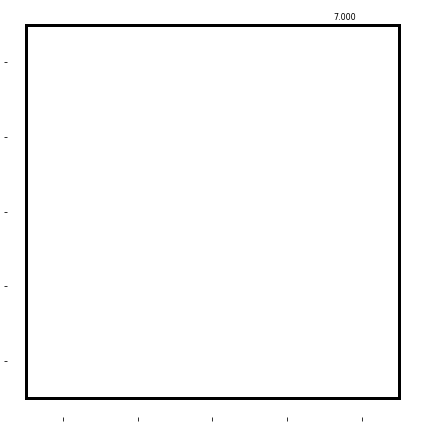

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.gridspec as gridspec
from sys import argv, exit

# Override params if argv[1] == plot
if len(argv) > 1:
    if argv[1] == 'plot': do_plots = True

# Take the first values in the lists of parameters given in params.py
N = N_list[0]
v0 = v0_list[0]
R = R_list[0]

# If fixed density, adjust box size
if fixed_density == True:
    L = np.sqrt(N/density)
else:
    L = L0

# Eta steps through the values in this array
eta_vals = np.linspace(eta_start, eta_finish, N_eta_vals)
eta_i = 0
eta_i_max = N_eta_vals - 1


# Coefficicents
V_coeff = 1.0 / (N*v0) # normalisation factor for order parameter
chi_coeff = L**2 # N/density


############################
## Animate particles only ##
############################
def animate():
    
    # Initialise model
    state = initial(L, N, v0, R, eta_start)

    # Create plot without axes or ticks
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(bottom='off', left='off')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')
    
    # Create box
    box = plt.Rectangle((-L/2,-L/2), L, L, ec='none', lw=3, fc='none')
    box.set_edgecolor('k')
    ax.add_patch(box)

    # Text displaying current value of noise
    eta_text = ax.text(0.65*(L/2), 1.03*(L/2), "", fontsize=8)
   
    # Initialise particles and leaders
    particles, = ax.plot([], [], 'bo')
    leaders, = ax.plot([], [], 'mo')
    particles.set_markersize(ms)
    leaders.set_markersize(lms)

    def init():
        particles.set_data([], [])
        leaders.set_data([], [])
        eta_text.set_text("%.3f" %eta_start)
        return particles, leaders, box, eta_text
                
    def update(t):
               
        # Get eta for this timestep (integer divide isn't too slow)
        eta_i = min(t/steps_per_eta_val, eta_i_max)
        eta = eta_vals[eta_i]
        eta_text.set_text("$\eta=$%g" %eta)

        # All particles take one step
        model.step(state, L, N, v0, R, eta, t)
        t = t+1
    
        # Update animation
        particles.set_data(state[:, 0], state[:, 1])
        leaders.set_data(state[range(N_ldr),0], state[range(N_ldr),1])
        
        return particles, leaders, box, eta_text

    ani = anim.FuncAnimation(fig, update, interval=10, blit=True, init_func=init)

    plt.tight_layout()
    plt.show()
    
    return ani
    

###########################################################
## Animate particles, order parameter and susceptibility ##
###########################################################
def animate_plots():
    
    # Initialise model
    state = init(L, N, v0, R, eta_start)

    # Create plots with size ratio
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,1])
    ax = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
   
    # Particles animation
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(bottom='off', left='off')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')

    # Create box
    box = plt.Rectangle((-L/2,-L/2), L, L, ec='none', lw=3, fc='none')
    box.set_edgecolor('k')
    ax.add_patch(box)
    
    # Text displaying current value of noise
    eta_text = ax.text(0.65*(L/2), 1.03*(L/2), "", fontsize=8)
   
    # Initialise particles and leaders
    particles, = ax.plot([], [], 'bo')
    leaders, = ax.plot([], [], 'mo')
    particles.set_markersize(ms)
    leaders.set_markersize(lms)

    # Order parameter
    ax2.set_title("Order parameter")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("V")
    ax2.set_ylim(0, 1.0)
    V_plot, = ax2.plot([], [], 'g')
    V_series = []
    V_mean_series = []
    t_series = []

    # Susceptibility
    ax3.set_title("Susceptibility")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("$\chi$")
    chi_plot, = ax3.plot([], [], 'r')
    chi_series = []

    def init():
        particles.set_data([], [])
        leaders.set_data([], [])
        eta_text.set_text("%.3f" %eta_start)
        V_plot.set_data([], [])
        chi_plot.set_data([], [])
        return particles, leaders, box, eta_text, V_plot, chi_plot
                
    def update(t):
        
        # Get eta for this timestep
        eta_i = min(t/steps_per_eta_val, eta_i_max)
        eta = eta_vals[eta_i]
        eta_text.set_text("$\eta=$%g" %eta)
        
        # All particles take one step
        model.step(state, L, N, v0, R, eta, t)
        V = model.order_parameter(state, V_coeff)
        V_series.append(V)
        t = t+1
        
        # Update particle animation
        particles.set_data(state[:, 0], state[:, 1])
        leaders.set_data(state[range(N_ldr),0], state[range(N_ldr),1])
       
        # Take average of 'window' data points every 'plot_step' steps
        if t > window and t % plot_step == 0:
            # Do averages
            V_window = np.array(V_series[-window:])
            V_mean = np.mean(V_window)
            Vsq_mean = np.mean(V_window*V_window)
            chi = chi_coeff * (Vsq_mean - V_mean*V_mean)
            
            # Update data lists
            V_mean_series.append(V_mean)
            chi_series.append(chi)
            t_series.append(t*dt)
            
            # Update animated plots
            V_plot.set_data(t_series, V_mean_series)
            chi_plot.set_data(t_series, chi_series)

            # Update limits if necessary
            tmax = ax2.get_xlim()[1]
            chimax = np.max(chi_series)
            if t > tmax or chi > chimax:
                ax2.set_xlim(0, 2*tmax)
                ax3.set_xlim(0, 2*tmax)
                ax3.set_ylim(0, 1.1*chimax)
                ax2.figure.canvas.draw()
                ax3.figure.canvas.draw()
            
        return particles, leaders, box, eta_text, V_plot, chi_plot
    
    ani = anim.FuncAnimation(fig, update, interval=10, blit=True, init_func=init)

    plt.tight_layout()
    plt.show()
    
    return ani
    

if do_plots == True:
    outer_ani = animate_plots()
else:
    outer_ani = animate()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as mpl_pdf
import matplotlib.gridspec as gridspec
from sys import argv, exit


# Third argument variable can tell us to save figure(s)
if len(argv) > 3 and argv[3] == 'save':
    save = True
else:
    save = False

#####################
## Plot a snapshot ##
#####################
if argv[1] == 'state':

    # Load data given as second argument variable
    input_data = np.loadtxt(argv[2])
    
    # Separate into parameters and state
    L, N, v0, R, eta = input_data[0,:]
    state = input_data[1:,:]

    # Create plot without axes or ticks
    fig, ax = plt.subplots()
    ax.set_title("$L=$%g, $N=$%g, $v_0=$%g, $R=$%g, $\eta=$%g" %(L,N,v0,R,eta))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(bottom='off', left='off')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')

    # Create box
    box = plt.Rectangle((-L/2,-L/2), L, L, ec='none', lw=3, fc='none')
    box.set_edgecolor('k')
    ax.add_patch(box)

    # Plot positions and velocities
    ax.quiver(state[:,0], state[:,1], state[:,3], state[:,4])

    # If argv[3] = save, save the figure
    if save == True:
        fig_file = argv[2].replace('.out','.png')
        fig.savefig(fig_file)

    plt.show()
   

    exit(0)


#####################
## Plot statistics ##
#####################
# Argument variables tell us how to organise the data into plots
# Possible values:   'N', 'v0', 'R', 'eta'
x_var = argv[1] # values of this variable on the x-axis
lines_var = argv[2] # values of this variable are different lines on the same plot

# Open pdf for saving
if save == True:
    save_pdf = mpl_pdf.PdfPages(save_name+".pdf")

# Quick check that argument variables are valid
plot_vars = ['N','v0','R','eta']
if x_var not in plot_vars or lines_var not in plot_vars:
    print ("Error: invalid argument(s)")
    exit(1)

# The other two variables will be separated into separate plots
plot_vars.remove(x_var)
plot_vars.remove(lines_var)

# Load data output by main.py
save_file = save_name + ".out"
input_data = np.loadtxt(save_file)

# Create dictionary to link string variables with indices for input_data
index_dict = {'L': 0, 'N': 1, 'v0': 2, 'R': 3, 'eta': 4,
              'V': 5, 'eV': 6, 'chi': 7, 'echi': 8, 'U': 9, 'eU': 10}

# Dictionary so that the x-label and plot symbols are a little more fancy
xlabel_dict = {'N': "Number of particles", 'v0': "Particle velocity",
               'R': "Interaction radius", 'eta': "Magnitude of heading noise"}
symb_dict = {'N': "$N$", 'v0': "$v_0$", 'R': "$R$", 'eta': "$\eta$"}


# Iterate over unique values of the first variable in plot_vars
for I in set(list( input_data[:, index_dict[plot_vars[0]] ] )):
    Irows = np.where( input_data[:, index_dict[plot_vars[0]] ] == I )[0]
    Idata = input_data[Irows, :]
    
    # Now over unique values of the second variable in plot_vars
    for J in set(list( Idata[:, index_dict[plot_vars[1]] ] )):
        IJrows = np.where( Idata[:, index_dict[plot_vars[1]] ] == J )[0]
        IJdata = Idata[IJrows, :]

        # Create plots
        fig = plt.figure(figsize=(8,4))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1])
        ax = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        ax3 = plt.subplot(gs[2])
        
        ax2.set_title("%s = %g, %s = %g" 
                %(symb_dict[plot_vars[0]], I, symb_dict[plot_vars[1]], J) )
        ax.set_ylabel("Order parameter ($V$)")
        ax2.set_ylabel("Susceptibility ($\chi$)")
        ax3.set_ylabel("Binder cumulant ($U$)")
        ax.set_xlabel(xlabel_dict[x_var]+" ("+symb_dict[x_var]+")")
        ax2.set_xlabel(xlabel_dict[x_var]+" ("+symb_dict[x_var]+")")
        ax3.set_xlabel(xlabel_dict[x_var]+" ("+symb_dict[x_var]+")")

        # For each unique value of lines_var, plot a line
        for K in set(list( IJdata[:, index_dict[lines_var] ] )):
            IJKrows = np.where( IJdata[:, index_dict[lines_var] ] == K )[0]
            IJKdata = IJdata[IJKrows, :]

            # x_var plotted along x-axis
            xdata = IJKdata[:, index_dict[x_var] ]

            # Get indices which sort xdata into ascending order
            srted = np.argsort(xdata)
            xdata = xdata[ srted ]
            
            # Plot Order parameter, susceptibility and Binder cumulent
            ax.errorbar(xdata, IJKdata[srted, index_dict['V'] ], 
                    yerr=IJKdata[srted, index_dict['eV'] ], fmt='.-')
            ax2.errorbar(xdata, IJKdata[srted, index_dict['chi'] ], 
                    yerr=IJKdata[srted, index_dict['echi'] ], fmt='.-')
            ax3.errorbar(xdata, IJKdata[srted, index_dict['U'] ], 
                    yerr=IJKdata[srted, index_dict['eU'] ], fmt='.-',
                    label="%s=%g" %(symb_dict[lines_var],K) )

        ax3.legend()
        plt.tight_layout()
    
        # Add the figure to the open pdf file
        if save == True:
            save_pdf.savefig(fig)
        
        plt.show()

# Close the pdf
if save == True:
    save_pdf.close()

Error: invalid argument(s)


SystemExit: 1